# Train microstructure classifier model and apply on gSZD

#### Authors: L. Banko, Y. Lysogorskiy

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [112]:
from keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, GlobalAveragePooling1D, MaxPooling2D,Activation
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Concatenate
from keras.models import Model
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox,TextArea
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib import cm
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import pandas as pd
from PIL import Image
import glob

import os
from os import listdir
from os.path import isfile, join

SX=64
SY=64
N_CHANNELS=1
INPUT_SHAPE=(SX,SY,N_CHANNELS)

# Loading data

crop images by 128 x 128, downsample to 64 x 64

In [5]:
DATA_PATH = ".."
IMAGE_SUBPATH=".."

In [6]:
df=pd.read_csv(os.path.join(DATA_PATH,".."),sep=";")

In [7]:
Y_COLUMNS=['temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]',
       'label']

In [8]:
im_scaler = MinMaxScaler()
BOX_SIZE=128

BATCH_SIZE=16
CROP_PER_IMAGE=128

batch_count = int(np.ceil(len(df)/BATCH_SIZE))
YS = []
XS = []


for b in range(0, batch_count):
    print(b*BATCH_SIZE,"->",min(len(df),b*BATCH_SIZE+BATCH_SIZE)-1)

    batch_indices = np.arange(b*BATCH_SIZE,min(len(df),b*BATCH_SIZE+BATCH_SIZE))


    for ind in batch_indices:    
        fname=df["file name"].loc[ind]
        fname=os.path.join(DATA_PATH,IMAGE_SUBPATH,fname)
        im=Image.open(fname)
        for rep in range(CROP_PER_IMAGE):        
            left=np.random.randint(0,im.width-BOX_SIZE)
            upper=np.random.randint(0,im.height-BOX_SIZE)

            box=left, upper, left+BOX_SIZE, upper+BOX_SIZE

            sub_image=im.crop(box)

            sub_image=sub_image.resize((SX,SY),resample=Image.ANTIALIAS)
            sub_image_np=np.array(sub_image).reshape(SX,SY,1)

            sub_image_np=((sub_image_np-127.5)/127.5).reshape(SX,SY,1)
            YS.append(df.loc[ind,Y_COLUMNS].values)
            XS.append(sub_image_np)

0 -> 15
16 -> 31
32 -> 47
48 -> 63
64 -> 79
80 -> 95
96 -> 111
112 -> 122


In [9]:
len(YS)

15744

In [10]:
len(XS)

15744

In [11]:
YS = np.array(YS)
XS = np.array(XS)


In [12]:
YS.shape

(15744, 7)

In [13]:
scaler = MinMaxScaler()
YS_scaled=scaler.fit_transform(YS[:,0:-1])

#encode labels
le = preprocessing.LabelEncoder()
le.fit(YS[:,6])
y_label_ =le.transform(YS[:,6])

#calculate class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_label_),y_label_)

#convert labels to categorical
y_label = keras.utils.to_categorical(y_label_, num_classes=None, dtype='float32')

#shuffling
x_data, y_data,y_label = shuffle(XS, YS,y_label, random_state=42)

# train test split
x_train,x_test, y_train, y_test, y_label_train,y_label_test = train_test_split(x_data, y_data,y_label, test_size=0.2)

#train validation split
x_train,x_val, y_train, y_val, y_label_train,y_label_val = train_test_split(x_train, y_train,y_label_train,  test_size=0.3)


C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
N_CLASSES = len(np.unique(YS[:,6]))
N_CLASSES


6

### build classifier model

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=XS[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))


In [17]:
patience = 3
        
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=0)]

### train structure classifier model

In [18]:
history = model.fit(x_train, y_label_train, 
        validation_data=(x_val,y_label_val),
        epochs=50, batch_size=25, callbacks=callbacks,class_weight=class_weights)

Train on 8816 samples, validate on 3779 samples
Epoch 1/50
8816/8816 [==============================] - 6s 730us/step - loss: 1.1933 - acc: 0.4707 - val_loss: 0.7711 - val_acc: 0.6854
Epoch 2/50
8816/8816 [==============================] - 2s 263us/step - loss: 0.6819 - acc: 0.7281 - val_loss: 0.4671 - val_acc: 0.8243s - loss: 0.
Epoch 3/50
8816/8816 [==============================] - 2s 262us/step - loss: 0.5270 - acc: 0.8054 - val_loss: 0.4166 - val_acc: 0.83700.5567
Epoch 4/50
8816/8816 [==============================] - 2s 260us/step - loss: 0.4075 - acc: 0.8504 - val_loss: 0.3456 - val_acc: 0.8682
Epoch 5/50
8816/8816 [==============================] - 2s 261us/step - loss: 0.3469 - acc: 0.8735 - val_loss: 0.2616 - val_acc: 0.9053
Epoch 6/50
8816/8816 [==============================] - 2s 266us/step - loss: 0.2926 - acc: 0.8917 - val_loss: 0.2623 - val_acc: 0.9010
Epoch 7/50
8816/8816 [==============================] - 2s 259us/step - loss: 0.2631 - acc: 0.9064 - val_loss: 0.2284 

In [113]:
model.save('structure_classifier.h5')

In [21]:
model.evaluate(x_test,y_label_test)

3149/3149 [==============================] - 0s 90us/step


[0.2517038869806682, 0.923150206433663]

### functions to generate images and visualize

In [54]:
def generate_latent_points(latent_dim, n_samples, n_classes=EXTRINSIC_DIM):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.choice(len(YS),size=n_samples)
    #weights = WEIGHTS[labels]
    labels=YS_scaled[labels]    
    return z_input, labels#,weights

def create_randuni_process_vector(num_samples, set_zero,addition):
    process_vector = np.concatenate([
        np.reshape(np.random.uniform(20,600,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0,70,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0,10,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0.1,1.2,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(1,200,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0.5,1,num_samples),(num_samples,1))
    ],axis=1)
    process_vector = np.reshape(process_vector,(num_samples,6))
    process_vector[:,set_zero]=0
    if addition is not None and len(addition)>0:
        process_vector[:,:]=process_vector[:,:]+addition
    process_vector = scaler.transform(process_vector)

    return process_vector


def create_grid_process_vector(num_samples,parameters_tail = [1,2,3,4],  set_zero =None,addition=None):
    par1 = np.linspace(20,600,num_samples)
    par2 = np.linspace(0,70,num_samples)
    process_vector = np.array([[p1,p2]+parameters_tail for p1 in par1 for p2 in par2])
    if set_zero is not None:
        process_vector[:,set_zero]=0
    if addition is not None and len(addition)>0:
        process_vector[:,:]=process_vector[:,:]+addition
    process_vector = scaler.transform(process_vector)
    return process_vector

# SZD plot
def gSZD_imscatter(x, y,img, ax,zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]

        image = img[i].reshape(plen, plen)

        image = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

# Comparison of 3 trained models

In [137]:
plt.rcParams.update({'font.size': 24,'xtick.major.width' : 1,'ytick.major.width' : 1,'axes.linewidth':1.5})

GENERATOR_WEIGHTS_PATH = '..'

In [138]:
generator_weights_files = [f for f in listdir(GENERATOR_WEIGHTS_PATH) if isfile(join(GENERATOR_WEIGHTS_PATH, f))]


### bins_6_total_batches_56320.0cgan_SZD_generator_20200205.h5

load generator model

In [139]:
WEIGHT_PATH = os.path.join(GENERATOR_WEIGHTS_PATH,generator_weights_files[0])
generator_model = load_model(WEIGHT_PATH)
latent_dim = 32


C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<Figure size 432x288 with 0 Axes>

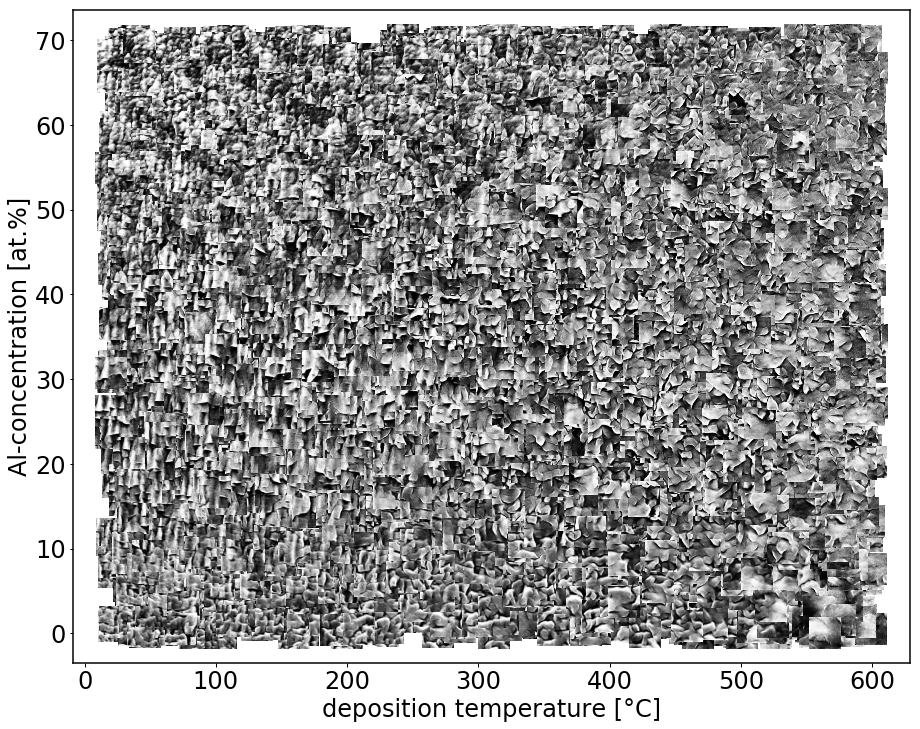

In [140]:
plt.gray()
num_pred = 4000
plen = 64

latent_points, labels = generate_latent_points(latent_dim, num_pred)
del labels


add_ = [0,0,1.0,1.0,40,0.5]
pp = create_randuni_process_vector(num_pred,[2,3,4,5],add_)
X_test  = generator_model.predict([latent_points, pp])

pp=scaler.inverse_transform(pp)

fig, ax = plt.subplots(figsize=(15, 12))
gSZD_imscatter(pp[:,0],pp[:,1],X_test,ax,.5)
plt.ylabel('Al-concentration [at.%]')
plt.tick_params(axis='both', which='major')
plt.xlabel('deposition temperature [°C]')
plt.savefig(generator_weights_files[0]+'.png',dpi = 150)

In [141]:
plt.gray()
num_pred = 3000
plen = 64
points_per_axis = 50
pp = create_grid_process_vector(points_per_axis,parameters_tail = [1.0,1.0,40,0.5], addition = None)

preds = []
for _ in range(100):
    print(_)
    z_input, labels_input = generate_latent_points(32, points_per_axis*points_per_axis)
    MS = generator_model.predict([z_input, pp])
    pred = model.predict(MS)    
    preds.append(pred)    


pp=scaler.inverse_transform(pp)
pred_ave = np.mean(preds,axis=0)
pred_std = np.std(preds,axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Figure size 432x288 with 0 Axes>

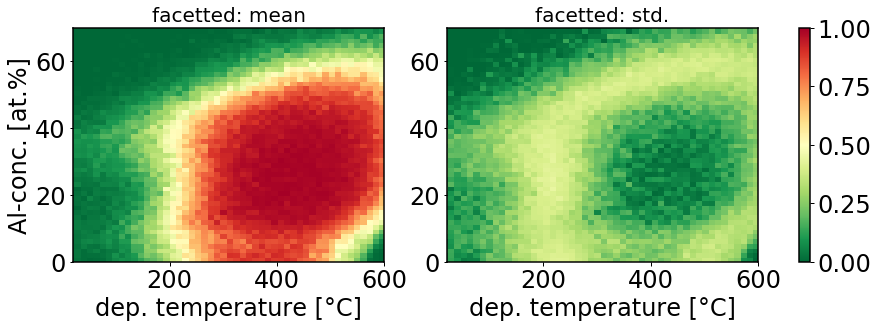

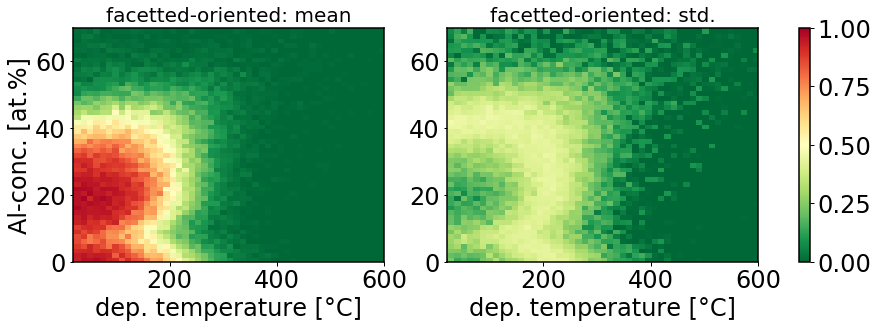

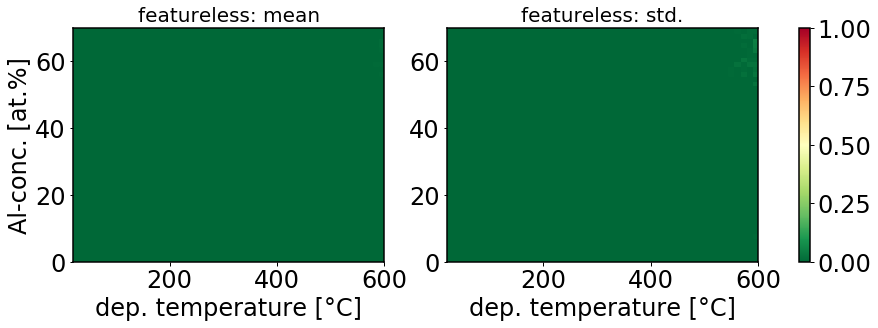

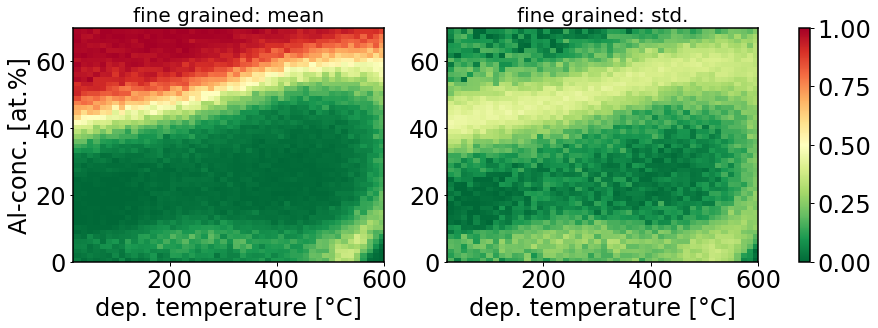

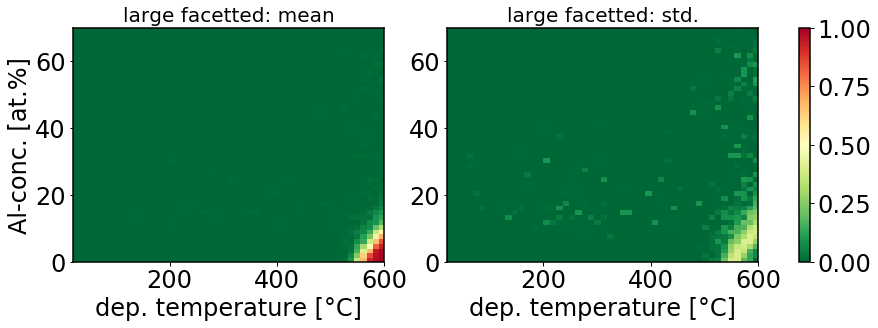

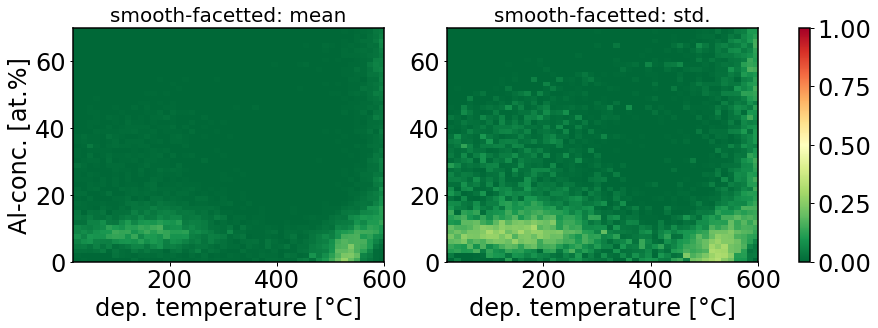

In [142]:
cmap='RdYlGn_r'

for i in range(y_label_train.shape[1]):
    fig, axs = plt.subplots(1,2,figsize=(14,5))
    im = axs[0].scatter(pp[:,0],pp[:,1],c=pred_ave[:,i],cmap=cmap, vmin = 0, vmax = 1,s=100, marker='s')
    axs[1].scatter(pp[:,0],pp[:,1],c=pred_std[:,i],cmap=cmap, vmin = 0, vmax = 1,s=100, marker='s')
    axs[0].set_title(le.classes_[i]+': mean',fontsize = 20)
    axs[0].set_xlim(20,600)
    axs[0].set_ylim(0,70)
    axs[0].set_ylabel('Al-conc. [at.%]')
    axs[0].set_xlabel('dep. temperature [°C]')
    
    axs[1].set_xlim(20,600)
    axs[1].set_ylim(0,70)
    axs[1].set_title(le.classes_[i]+': std.',fontsize = 20)
    axs[1].set_xlabel('dep. temperature [°C]')
    
    plt.subplots_adjust(bottom=0.2, left=0.1,right=0.9, top=0.85)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=.1)
    plt.savefig(generator_weights_files[0]+'_'+le.classes_[i]+'.png')

### bins_6__total_batches_56320.0cgan_SZD_generator_20200114.h5

load generator model

In [143]:
WEIGHT_PATH = os.path.join(GENERATOR_WEIGHTS_PATH,generator_weights_files[1])
generator_model = load_model(WEIGHT_PATH)
EXTRINSIC_DIM = 6
latent_dim = 32


C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<Figure size 432x288 with 0 Axes>

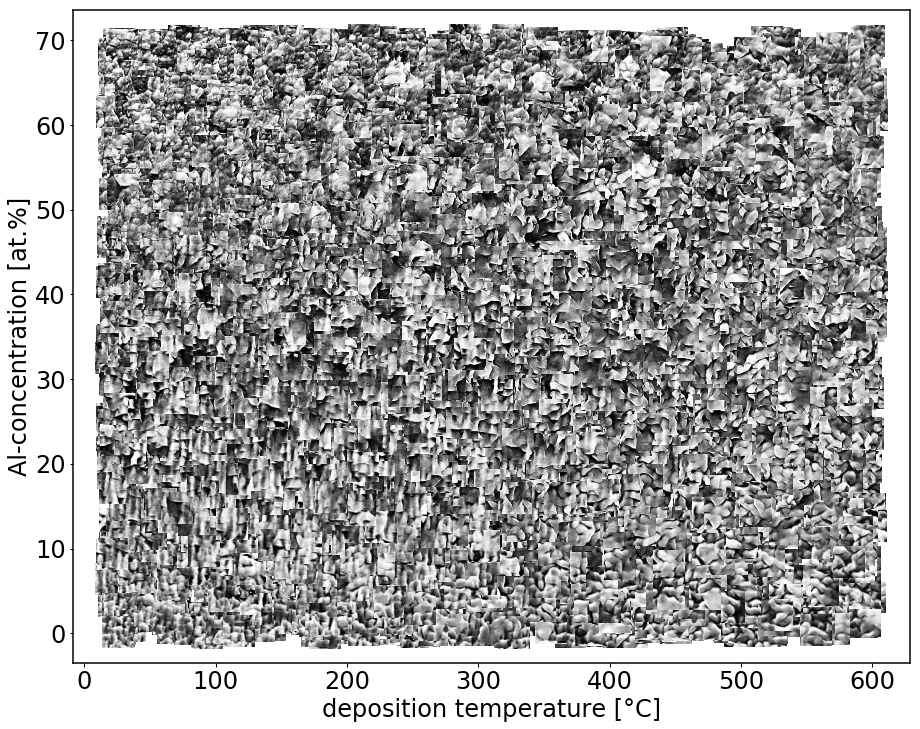

In [144]:
plt.gray()
num_pred = 4000
plen = 64

latent_points, labels = generate_latent_points(latent_dim, num_pred)
del labels


add_ = [0,0,1.0,1.0,40,0.5]
pp = create_randuni_process_vector(num_pred,[2,3,4,5],add_)
X_test  = generator_model.predict([latent_points, pp])

pp=scaler.inverse_transform(pp)

fig, ax = plt.subplots(figsize=(15, 12))
gSZD_imscatter(pp[:,0],pp[:,1],X_test,ax,.5)
plt.ylabel('Al-concentration [at.%]')
plt.tick_params(axis='both', which='major')
plt.xlabel('deposition temperature [°C]')
plt.savefig(generator_weights_files[1]+'.png',dpi = 150)

In [145]:
plt.gray()
num_pred = 3000
plen = 64
points_per_axis = 50
pp = create_grid_process_vector(points_per_axis,parameters_tail = [1.0,1.0,40,0.5], addition = None)

preds = []
for _ in range(100):
    print(_)
    z_input, labels_input = generate_latent_points(32, points_per_axis*points_per_axis)
    MS = generator_model.predict([z_input, pp])
    pred = model.predict(MS)    
    preds.append(pred)    


pp=scaler.inverse_transform(pp)
pred_ave = np.mean(preds,axis=0)
pred_std = np.std(preds,axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Figure size 432x288 with 0 Axes>

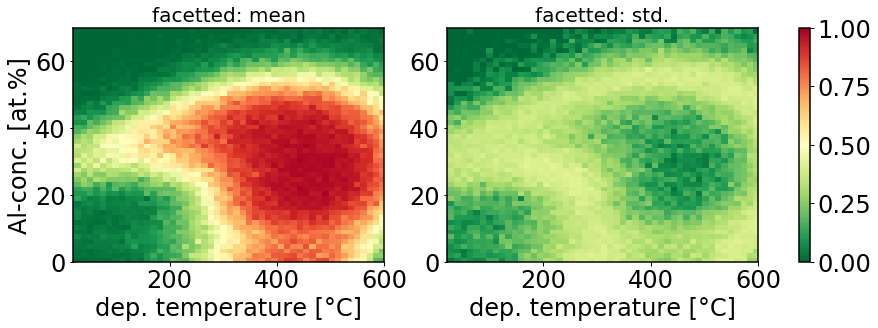

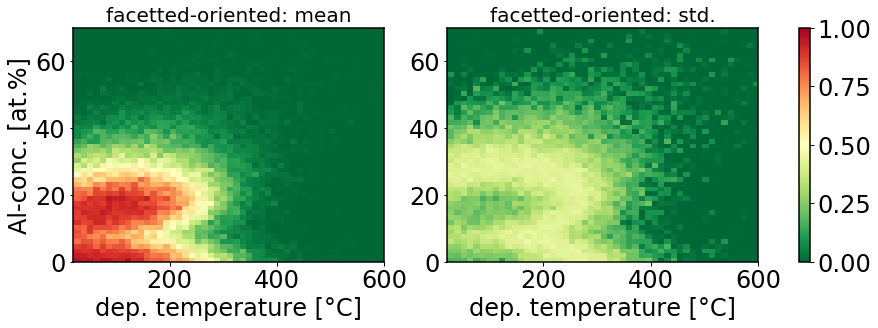

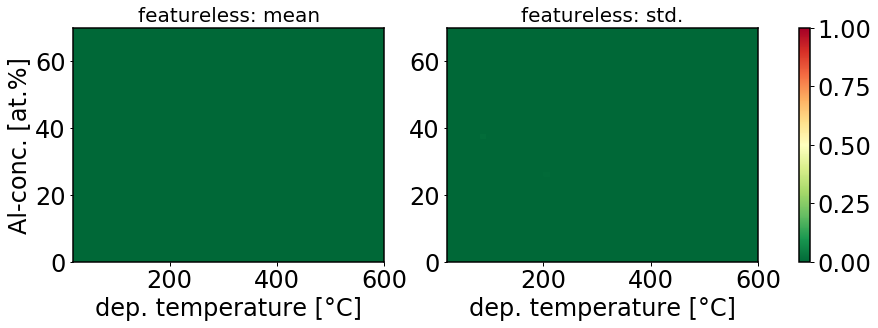

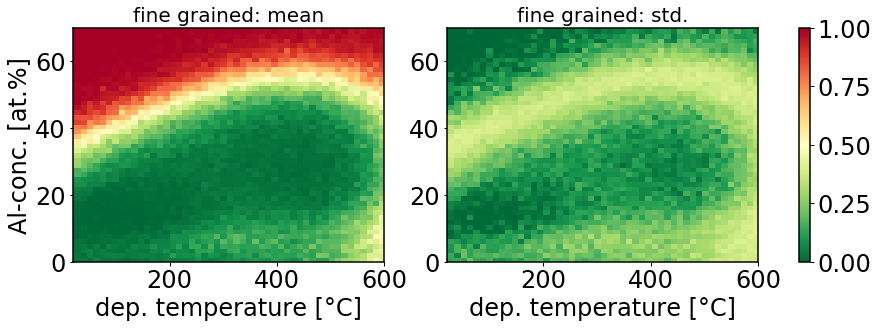

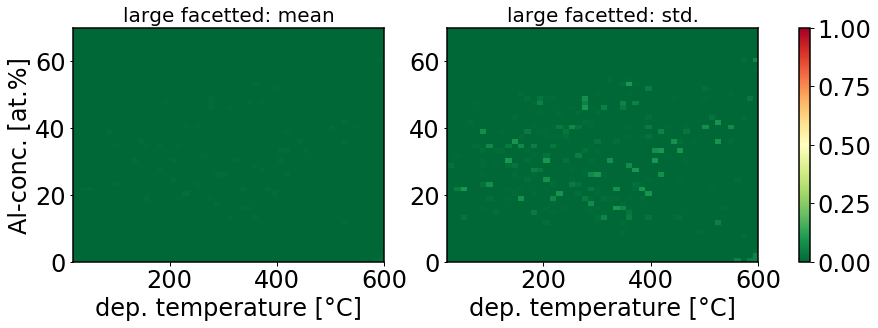

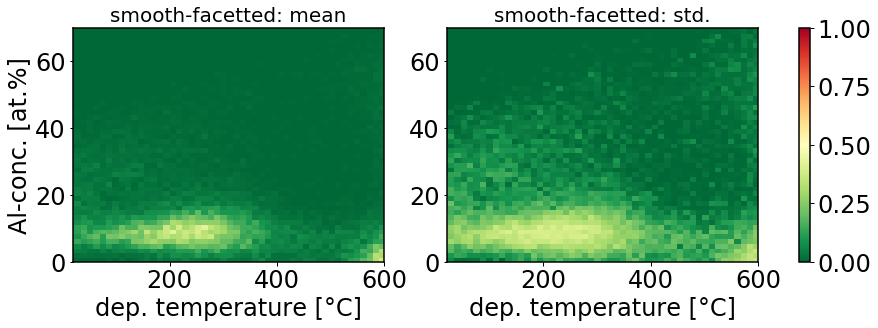

In [146]:
cmap='RdYlGn_r'

for i in range(y_label_train.shape[1]):
    fig, axs = plt.subplots(1,2,figsize=(14,5))
    im = axs[0].scatter(pp[:,0],pp[:,1],c=pred_ave[:,i],cmap=cmap, vmin = 0, vmax = 1,s=100, marker='s')
    axs[1].scatter(pp[:,0],pp[:,1],c=pred_std[:,i],cmap=cmap, vmin = 0, vmax = 1,s=100, marker='s')
    axs[0].set_title(le.classes_[i]+': mean',fontsize = 20)
    axs[0].set_xlim(20,600)
    axs[0].set_ylim(0,70)
    axs[0].set_ylabel('Al-conc. [at.%]')
    axs[0].set_xlabel('dep. temperature [°C]')
    
    axs[1].set_xlim(20,600)
    axs[1].set_ylim(0,70)
    axs[1].set_title(le.classes_[i]+': std.',fontsize = 20)
    axs[1].set_xlabel('dep. temperature [°C]')
    
    plt.subplots_adjust(bottom=0.2, left=0.1,right=0.9, top=0.85)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=.1)
    plt.savefig(generator_weights_files[1]+'_'+le.classes_[i]+'.png')

### bins_6__total_batches_56320.0cgan_SZD_generator_20200117.h5

load generator model

In [147]:
WEIGHT_PATH = os.path.join(GENERATOR_WEIGHTS_PATH,generator_weights_files[2])
generator_model = load_model(WEIGHT_PATH)
EXTRINSIC_DIM = 6
latent_dim = 32


C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<Figure size 432x288 with 0 Axes>

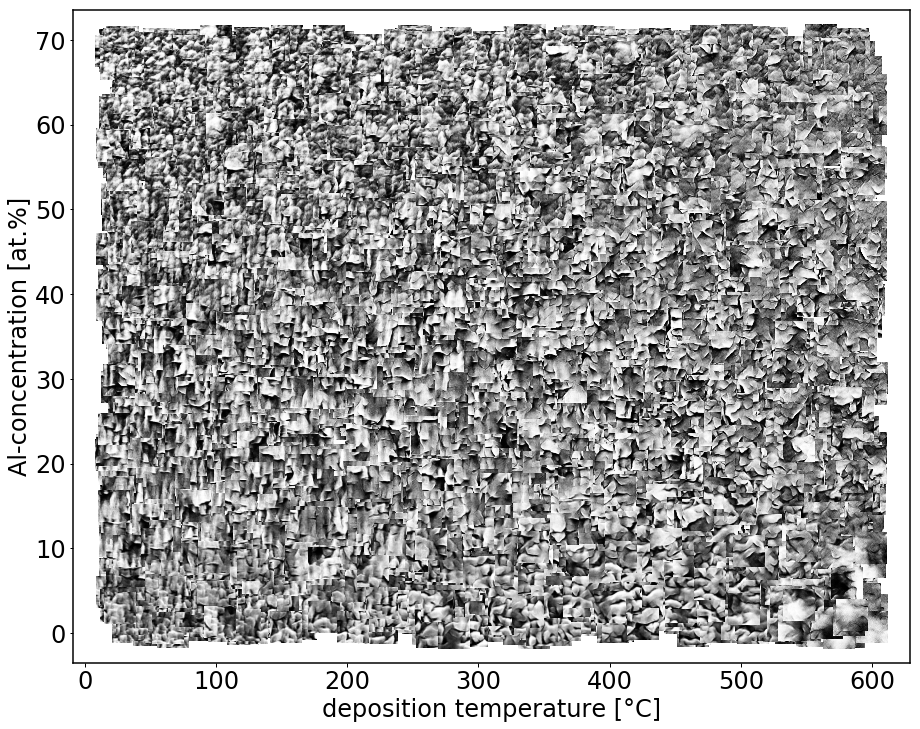

In [148]:
plt.gray()
num_pred = 4000
plen = 64

latent_points, labels = generate_latent_points(latent_dim, num_pred)
del labels


add_ = [0,0,1.0,1.0,40,0.5]
pp = create_randuni_process_vector(num_pred,[2,3,4,5],add_)
X_test  = generator_model.predict([latent_points, pp])

pp=scaler.inverse_transform(pp)

fig, ax = plt.subplots(figsize=(15, 12))
gSZD_imscatter(pp[:,0],pp[:,1],X_test,ax,.5)
plt.ylabel('Al-concentration [at.%]')
plt.tick_params(axis='both', which='major')
plt.xlabel('deposition temperature [°C]')
plt.savefig(generator_weights_files[2]+'.png',dpi = 150)

In [149]:
plt.gray()
num_pred = 3000
plen = 64
points_per_axis = 50
pp = create_grid_process_vector(points_per_axis,parameters_tail = [1.0,1.0,40,0.5], addition = None)

preds = []
for _ in range(100):
    print(_)
    z_input, labels_input = generate_latent_points(32, points_per_axis*points_per_axis)
    MS = generator_model.predict([z_input, pp])
    pred = model.predict(MS)    
    preds.append(pred)    


pp=scaler.inverse_transform(pp)
pred_ave = np.mean(preds,axis=0)
pred_std = np.std(preds,axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Figure size 432x288 with 0 Axes>

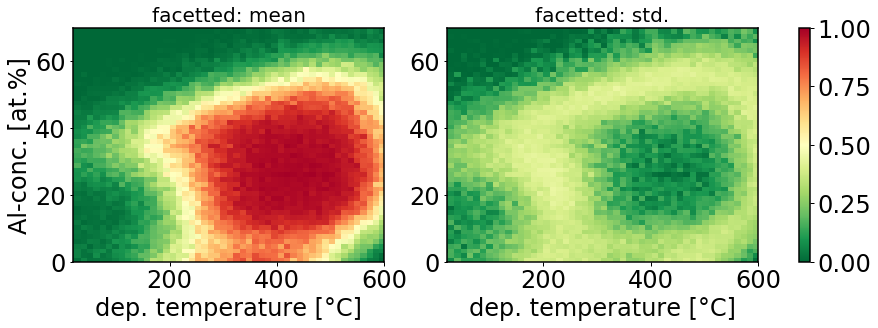

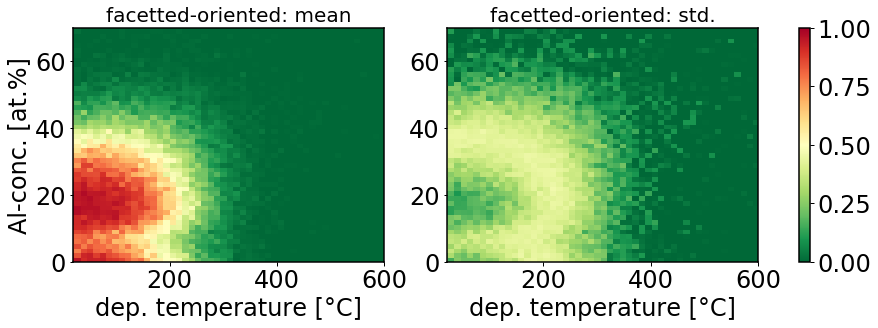

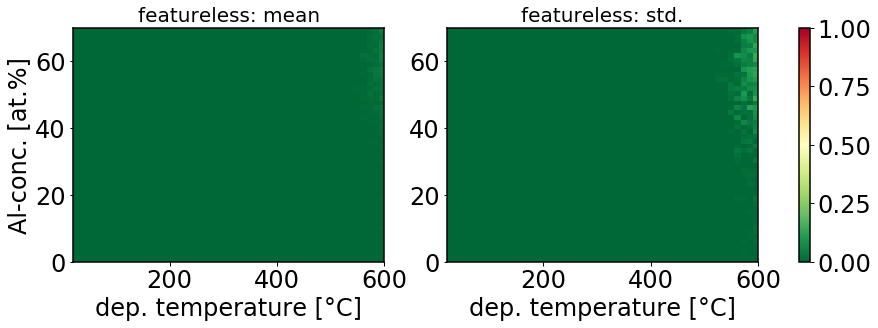

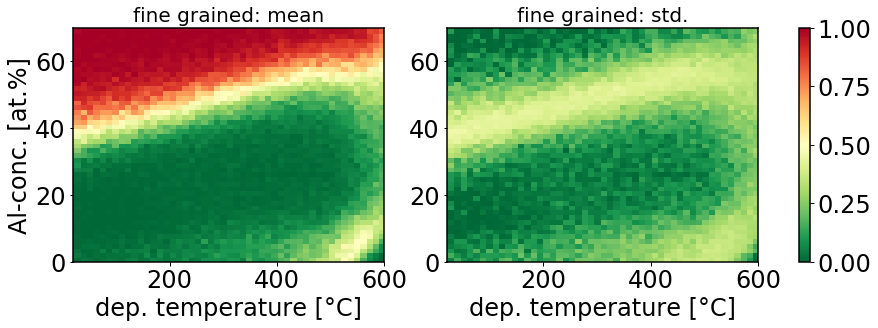

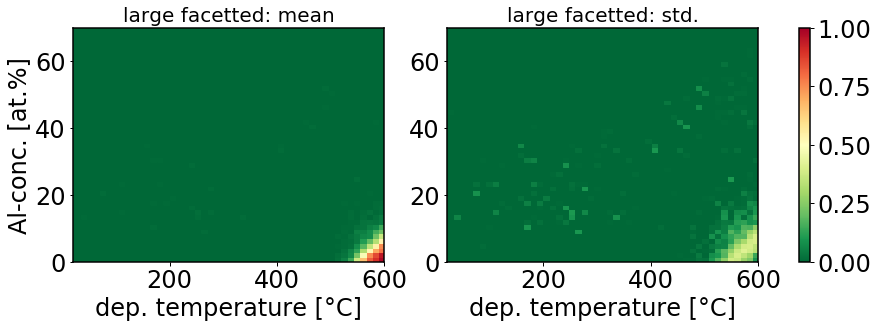

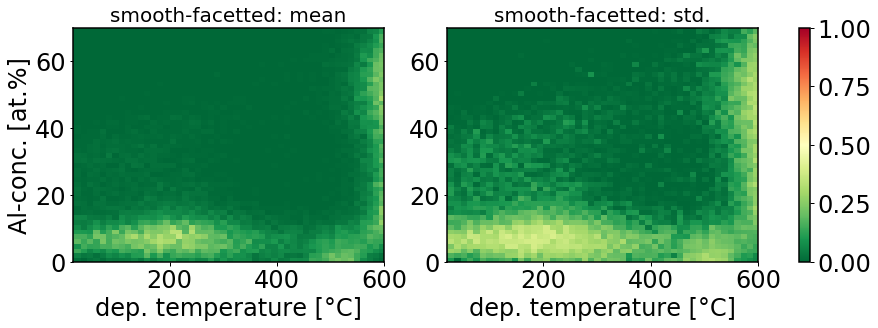

In [150]:
cmap='RdYlGn_r'

for i in range(y_label_train.shape[1]):
    fig, axs = plt.subplots(1,2,figsize=(14,5))
    im = axs[0].scatter(pp[:,0],pp[:,1],c=pred_ave[:,i],cmap=cmap, vmin = 0, vmax = 1,s=100, marker='s')
    axs[1].scatter(pp[:,0],pp[:,1],c=pred_std[:,i],cmap=cmap, vmin = 0, vmax = 1,s=100, marker='s')
    axs[0].set_title(le.classes_[i]+': mean',fontsize = 20)
    axs[0].set_xlim(20,600)
    axs[0].set_ylim(0,70)
    axs[0].set_ylabel('Al-conc. [at.%]')
    axs[0].set_xlabel('dep. temperature [°C]')
    
    axs[1].set_xlim(20,600)
    axs[1].set_ylim(0,70)
    axs[1].set_title(le.classes_[i]+': std.',fontsize = 20)
    axs[1].set_xlabel('dep. temperature [°C]')
    
    plt.subplots_adjust(bottom=0.2, left=0.1,right=0.9, top=0.85)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=.1)
    plt.savefig(generator_weights_files[2]+'_'+le.classes_[i]+'.png')